In [48]:
import importlib
import torch
from torchvision import transforms
from torch import nn, optim
import torch.nn.functional as F

from utils import layers, hooking, img, stats, models, losses, shift
from stepping import loss, closure

In [49]:
vgg = models.vgg19()

In [50]:
hooker = hooking.Hooker(vgg)
hooker.attach_hooks("smooth_hooks", [1])
hooker.attach_hooks("texture_hooks", [3, 6, 19, 26, 37])
hook_bag = hooker.get_bag()
vgg = layers.clipped_model(vgg, hooker.last_hooked_index())

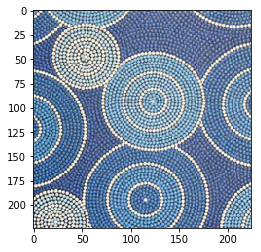

In [51]:
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.ToTensor(),
])

example_texture = img.image_loader("data/original/rings-2.jpg", transform)
img.show_image(example_texture)

In [97]:
importlib.reload(losses)
importlib.reload(shift)

vgg(example_texture)
target = stats.extract_features(hook_bag.get_hook("texture_hooks"), stats.gram_matrix)

def texture_loss_fn(target_grams, sample_features):
    sample_grams = [stats.gram_matrix(feature) for feature in sample_features]
    loss = 0
    
    for i in range(len(sample_grams)):
        loss += F.mse_loss(sample_grams[i], target_grams[i]) / len(sample_grams)  
    
    loss *= 100000000
    print("texture loss: {}".format(loss))
    return loss 

texture_loss = loss.LossFn(target, hook_bag.get_hook("texture_hooks"), texture_loss_fn)

def smooth_loss(_, sample_features):
    loss = 0
    for layer in sample_features:
        loss += losses.smoothing_loss(layer) * layer.numel()
    
    loss *= 1000
    print("smooth loss: {}".format(loss))
    return loss 

smoothness_loss = loss.LossFn(None, hook_bag.get_hook("smooth_hooks"), smooth_loss) 

In [98]:
collector = loss.LossCollector()
collector.add_loss_fn("texture", smoothness_loss)
collector.add_loss_fn("texture", texture_loss)

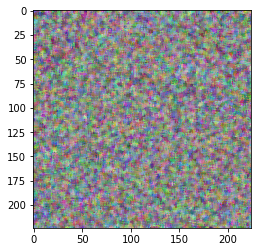

In [99]:
sample_texture = img.random_image(4, 224)
img.show_image(sample_texture)

inputs = {
    "input": sample_texture,
    "loss_name": "texture",
    "pyramid": False,
}

optimizer = optim.LBFGS([sample_texture])

In [100]:
stepper = closure.Stepper(inputs, vgg, collector, optimizer)

In [101]:
importlib.reload(stats)
importlib.reload(losses)

show_at = 1
for i in range(32):
    optimizer.step(stepper.loss_fn)
    
    if i + 1 == show_at:
        show_at *= 2
        img.save_image(sample_texture, "data/synth/sm{}.jpg".format(show_at))
    print(sample_texture.grad[0][0][0][:3])

tensor(4451697.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606786.25
texture loss: 144480.109375
tensor(4451697.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606786.25
texture loss: 144447.78125
tensor(4451690.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606791.75
texture loss: 118252.9296875
tensor(4451667.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606810.25
texture loss: 84600.5859375
tensor(4451621.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606848.0
texture loss: 63182.34375
tensor(4451597., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606867.25
texture loss: 47143.73828125
tensor(4451582.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606879.25
texture loss: 38720.203125
tensor(4451569., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606890.25
texture loss: 30750.216796875
tensor(4451549., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3606906.5
texture loss: 24

tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 441.2837829589844
tensor(4451428., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607004.5
texture loss: 426.564208984375
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 412.8026428222656
tensor(4451428., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607004.5
texture loss: 392.5646667480469
tensor(4451427., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.25
texture loss: 387.93255615234375
tensor(4451427., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.25
texture loss: 379.0653991699219
tensor(4451428., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607004.5
texture loss: 374.5618591308594
tensor(4451427., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.25
texture loss: 365.9442138671875
tensor(4451426., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607006.25
tex

tensor(4451421.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.75
texture loss: 119.76061248779297
tensor(4451421.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.75
texture loss: 117.76773071289062
tensor(4451422., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.25
texture loss: 116.30411529541016
tensor(4451422.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607008.75
texture loss: 115.47708892822266
tensor(4451422., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.25
texture loss: 114.36085510253906
tensor(4451422., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.25
texture loss: 113.44239044189453
tensor(4451422., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.25
texture loss: 112.1163558959961
tensor(4451422., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607009.25
texture loss: 110.51905822753906
tensor(4451422.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth 

tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 64.99281311035156
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 64.75765991210938
tensor(4451424.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 64.19000244140625
tensor(4451424.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 63.755733489990234
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 63.0817756652832
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 62.68535232543945
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 62.32437515258789
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.25
texture loss: 61.83936309814453
tensor(4451424., device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607007.2

tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 46.76939392089844
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 46.48360061645508
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 46.420841217041016
tensor([0.0033, 0.0141, 0.0079], device='cuda:0')
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 46.420841217041016
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 46.16796875
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 45.8837890625
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 45.661922454833984
tensor(4451427.5000, device='cuda:0', grad_fn=<SumBackward0>)
smooth loss: 3607005.0
texture loss: 45.46528625488281
tensor(4451427.5000, 